# Chinese text summarization algorithm
### www.KudosData.com
#### By: Sam GU Zhan
#### March, 2017

# Imports

In [1]:
# coding=UTF-8
from __future__ import division
import re

# Python2 unicode & float-division support:
# from __future__ import unicode_literals, division

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import io

# 中文字符和语言处理库
import jieba

# 机器学习库 sklearn 分类学习模型库
#from sklearn import linear_model
from sklearn.feature_extraction import DictVectorizer # 数据结构变换：把 Dict 转换为 稀疏矩阵
# from sklearn.linear_model import LogisticRegression  # 逻辑回归分类模型
# from sklearn.pipeline import make_pipeline # 封装机器学习模型流程
# from sklearn.metrics import confusion_matrix, roc_curve, auc

# 中文显示设置
from pylab import *  
mpl.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体  
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题 
mpl.rcParams['font.size'] = 14 # 设置字体大小

np.random.seed(88)

# Define Functions

In [3]:
# Python3
# 中文分词功能小函数， 输出 字符串， 各词组由空格分隔
def KudosData_word_tokenizer(foo):
    # remove lead & tail spaces firstly:
    foo = foo.strip()
    seg_token = jieba.cut(str(foo), cut_all=True)
    seg_str = str(' '.join(seg_token)).strip()

    return seg_str
# Python2
# 中文分词功能小函数， 输出 字符串， 各词组由空格分隔
# def KudosData_word_tokenizer(foo):
#     seg_token = jieba.cut(foo, cut_all=True)
#     seg_str = ' '.join(seg_token)
#     return seg_str

In [4]:
# Python3
# 中文分词功能小函数， 输出 dictionary： { key 词组， value 计数 }
def KudosData_word_count(foo):
    # remove lead & tail spaces firstly:
    foo = foo.strip()
    seg_token = jieba.cut(str(foo), cut_all=True)
    seg_str = str(' '.join(seg_token)).strip()
    seg_count = pd.value_counts(str(seg_str).lower().split(' '))
    seg_count = seg_count.to_dict() 
    seg_count.pop('', None) # remove EMPTY dict key: ''
    return seg_count
# Python2
# 中文分词功能小函数， 输出 dictionary： { key 词组， value 计数 }
# def KudosData_word_count(foo):
#     seg_token = jieba.cut(foo, cut_all=True)
#     seg_str = '^'.join(seg_token)
#     seg_count = pd.value_counts(seg_str.lower().split('^'))
#     return seg_count.to_dict()

# Input text

In [5]:
# process Unicode text input
with io.open('input_text.txt','r',encoding='utf8') as f:
    content = f.read()

title = '''
<Dummy Title>
'''

In [6]:
# content

In [7]:
def format_sentence(text):
#     sentence = re.sub(r'\W+', '#', sentence)
    text = re.sub(r'\t+', '', text) # remove one or more Tab
    return text

In [8]:
def extract_valid_sentence_words(text):
    text = re.sub(r'\W+', '#', text.strip())
    return text

In [9]:
def linebreak_conversion_win_linux(text):
    text = re.sub(r'\r', '', text) # remove one or more Tab
    text = re.sub(r'\u3000', ' ', text) # convert white space: \u3000    
    return text

In [10]:
def clean_some_whitespace(text): # Does not remove normal Space
#     sentence = re.sub(r'\W+', '#', sentence)
    text = re.sub(r'\t+', '', text) # remove one or more Tab
    text = re.sub(r'\f+', '', text) # remove one or more
    text = re.sub(r'\v+', '', text) # remove one or more
    text = re.sub(r'\n+', '', text) # remove one or more \n, this is to merge sentences within paragraph

    text = re.sub(r'(\^\*\#)( +)(\#\*\^)', '^*##*^', text) # remove one or more Spaces between Paragraph-Tags or Sentence-Tags

    text = re.sub(r' +', ' ', text) # merge two or more Spaces to 1 Space

    # remove lead & tail spaces:
    text =text.strip()

#     text = re.sub(r'( +)\W', r'\W', text) # remove Spaces before special char
#     text = re.sub(r'\W( +)', r'\W', text) # remove Spaces after special char
    
    return text

In [11]:
### Define Paragraph-Tag =  
#   #*^P^*#

### Define Sentence-Tag =  
#   #*^S^*#


In [12]:
# add a special tag to end of each paragraph
def tag_paragraph(text):
    text = re.sub(r'((\n ) +)+', '#*^P^*#', text) # Tag paragraph, pattern: \n + two or more Spaces
    text = re.sub(r'((\n\t) +)+', '#*^P^*#', text) # Tag paragraph, pattern: \n + two or more Tabs
    text = re.sub(r'(\n( *)\n)+', '#*^P^*#', text) # Tag paragraph, pattern: \n + zero or more Spaces + \n
    text = re.sub(r'(\#\*\^P\^\*\#)+', '#*^P^*#', text) # merge two or more Paragraph-Tags -> 1 Paragraph-Tag

    return text

In [13]:
# add a special tag to end of each sentence
def tag_sentence(text):
    text = re.sub(r'。+', '。#*^S^*#', text) # Tag sentence - Chinese
    text = re.sub(r'！+', '！#*^S^*#', text) # Tag sentence - Chinese
    text = re.sub(r'\？+', '？#*^S^*#', text) # Tag sentence - Chinese
    text = re.sub(r'；+', '；#*^S^*#', text) # Tag sentence - Chinese

    text = re.sub(r'!+', '!#*^S^*#', text) # Tag sentence - English
    text = re.sub(r'\?+', '?#*^S^*#', text) # Tag sentence - English
    text = re.sub(r';+', ';#*^S^*#', text) # Tag sentence - English
   
    # merge two or more sentence-Tags -> 1 Sentence-Tag
    text = re.sub(r'(\W?(\#\*\^S\^\*\#))+', '。#*^S^*#', text)

    # remove a Sentence-Tag immediately before an ending ”
    text = re.sub(r'\#\*\^S\^\*\#”', '”', text) 
    
    # remove a Sentence-Tag immediately before a Paragraph-Tag
    text = re.sub(r'(\#\*\^S\^\*\#)( *)(\#\*\^P\^\*\#)', '#*^P^*#', text) 
    
    text = re.sub(r'(\#\*\^P\^\*\#)+', '#*^P^*#', text) # merge two or more Paragraph-Tags -> 1 Paragraph-Tag

    
    return text

### Start tagging:

In [14]:
content_format = linebreak_conversion_win_linux(content)
# content_format

In [15]:
content_format = tag_paragraph(content_format)
# content_format

In [16]:
content_format = clean_some_whitespace(content_format)
# content_format

In [17]:
content_format = tag_sentence(content_format)
# content_format

In [18]:
content_format = clean_some_whitespace(content_format)
content_format

"Golden Age 《黄金时代》Wang xiaobo 王小波#*^P^*# one 一 #*^P^*#When I was twenty years old, I was jumping in Yunnan. 我二十一岁时，正在云南插队。#*^S^*# Chen Ching-yang was twenty-six years old, just when I jumped into the team as a doctor. 陈清扬当时二十六岁，就在我插队的地方当医生。#*^S^*# I am under the foot of the fourteen teams in the mountains, she fifteen teams in the mountains. 我在山下十四队，她在山上十五队。#*^S^*# One day she came down from the mountain, and I discussed her not the problem of shoes. 有一天她从山上下来，和我讨论她不是破鞋的问题。#*^S^*# At that time I did not know her, can only say that little know. 那时我还不大认识她，只能说有一点知道。#*^S^*# The thing she wants to discuss is this: though all the people say she is a broken shoe, but she thinks she is not. 她要讨论的事是这祥的：虽然所有的人都说她是一个破鞋，但她以为自己不是的。#*^S^*# Because the broken shoes to steal Han, and she did not laugh Han. 因为破鞋偷汉，而她没有愉过汉。#*^S^*# Although her husband had lived for one year, she had not stolen. 虽然她丈夫已经住了一年监狱，但她没有偷过汉。#*^S^*# Before this did not steal Han. 在此之前也未偷过汉。#*^S^*# So she simply do not understand


### Transfer tagged text to Pandas Dataframe

In [19]:
# Split a text into paragraphs
def split_article_to_paragraphs(text):
#     text = text.replace("#*^P^*#", "#*^S^*#") # convert Paragraph-Tag        
    return text.split("#*^P^*#")


In [20]:
# Split a paragraph into sentences
def split_paragraph_to_sentences(text):
#     text = text.replace("#*^P^*#", "#*^S^*#") # convert Paragraph-Tag        
    return text.split("#*^S^*#")


In [21]:
# 1st loop Paragraphs list, 2nd loop Sentences list
# create a few new columns, then write into dataframe, together with original Sentence string

# define empty dataframe:
df_article = pd.DataFrame(columns=('sentence', 
                                   'word_count', # sentence word count, including punctuations 
                                   'sentence_id', # unique sentence s/n within an article
                                   'sentence_id_paragraph',  # sentence s/n within a paragraph 
                                   'paragraph_id', 
                                   'class_rank', 
                                   'score_word', # score based on word tf-idf
                                   'score_sentence', # score based on intersection of sentence pairs
                                   'score_word_norm', # Normalized score
                                   'score_sentence_norm', # Normalized score
                                   'score',
                                  ))
df_sentence_id = 0

# split_article_to_paragraphs:
article_paragraphs = split_article_to_paragraphs(content_format)

for i in range(0, len(article_paragraphs)):
    # split_paragraph_to_sentences:
    article_paragraphs_sentences = split_paragraph_to_sentences(article_paragraphs[i].strip())

    for j in range(0, len(article_paragraphs_sentences)):
        if article_paragraphs_sentences[j].strip() != '':
            df_sentence_id = df_sentence_id + 1
            # write to dataframe:
            df_article.loc[len(df_article)] = [article_paragraphs_sentences[j].strip(), 
                                               len(article_paragraphs_sentences[j].strip()), 
                                               df_sentence_id, 
                                               j+1, 
                                               i+1, 
                                               '', 
                                               '', 
                                               '', 
                                               '', 
                                               '', 
                                               '']


In [22]:
# Make sure no empty sentences:
print('Number of empty sentences in dataframe: %d ' % len(df_article[df_article['sentence'] == '']))

Number of empty sentences in dataframe: 0 


In [23]:
df_article

,sentence,word_count,sentence_id,sentence_id_paragraph,paragraph_id,class_rank,score_word,score_sentence,score_word_norm,score_sentence_norm,score
0,Golden Age 《黄金时代》Wang xiaobo 王小波,32,1,1,1,,,,,,
1,one 一,5,2,1,2,,,,,,
2,"When I was twenty years old, I was jumping in ...",68,3,1,3,,,,,,
3,"Chen Ching-yang was twenty-six years old, just...",110,4,2,3,,,,,,
4,I am under the foot of the fourteen teams in t...,112,5,3,3,,,,,,
5,"One day she came down from the mountain, and I...",110,6,4,3,,,,,,
6,"At that time I did not know her, can only say ...",83,7,5,3,,,,,,
7,The thing she wants to discuss is this: though...,151,8,6,3,,,,,,
8,"Because the broken shoes to steal Han, and she...",81,9,7,3,,,,,,
9,"Although her husband had lived for one year, s...",87,10,8,3,,,,,,


In [24]:
# assume the 1st sentence as Title of Article

title = df_article['sentence'][0]
print('Title of Article : ', title)

Title of Article :  Golden Age 《黄金时代》Wang xiaobo 王小波


# Calculate importance score for each sentence

### [Optional Reference] word_tokenizer

In [25]:
# KudosData_word_tokenizer
df_article['sentence_tokenized'] = df_article['sentence'].apply(lambda x: KudosData_word_tokenizer(x))

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\TELESC~1\AppData\Local\Temp\jieba.cache
DEBUG:jieba:Loading model from cache C:\Users\TELESC~1\AppData\Local\Temp\jieba.cache
Loading model cost 1.836 seconds.
DEBUG:jieba:Loading model cost 1.836 seconds.
Prefix dict has been built succesfully.
DEBUG:jieba:Prefix dict has been built succesfully.


### [Optional Reference] Term Frequency

In [26]:
# KudosData_word_count
df_article['sentence_tf'] = df_article['sentence'].apply(lambda x: KudosData_word_count(x))

### [Optional Reference] TF-IDF

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = df_article['sentence_tokenized']

vectorizer = TfidfVectorizer()

# my_stopword_list = ['and','to','the','of', 'in']
#vectorizer = TfidfVectorizer(stop_words=my_stopword_list)

# choice of no nomalization of tfidf output (not recommended)
#vectorizer = TfidfVectorizer(norm=None)

# TF-IDF score
tfidf = vectorizer.fit_transform(corpus)

# IDF score
idf_dict = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

# TF is in df_article[['sentence_tf']]

In [28]:
### 把TF-iDF数值赋予相对应的词组
tfidf = tfidf.tocsr()

n_docs = tfidf.shape[0]
tfidftables = [{} for _ in range(n_docs)]
terms = vectorizer.get_feature_names()

for i, j in zip(*tfidf.nonzero()):
    tfidftables[i][terms[j]] = tfidf[i, j]

In [29]:
# Document-Term-Matrix's TF-IDF matrix size:
print ('This tfidf matrix is a very large table: [ %d rows/docs X %d columns/words ]' 
       % (tfidf.shape[0], tfidf.shape[1]))
print ('It contains %d eliments: one score per word per document !'
       % (tfidf.shape[0] * tfidf.shape[1]))

This tfidf matrix is a very large table: [ 94 rows/docs X 955 columns/words ]
It contains 89770 eliments: one score per word per document !


In [30]:
# Add tfidf score into dataframe 
df_article['tfidf'] = tfidftables

In [31]:
# df_article[['sentence', 'sentence_tokenized', 'tfidf']].head()
df_article[['sentence', 'sentence_tokenized', 'sentence_tf', 'tfidf']]

,sentence,sentence_tokenized,sentence_tf,tfidf
0,Golden Age 《黄金时代》Wang xiaobo 王小波,Golden Age 黄金 黄金时代 时代 Wang xiaobo 王小波 小波,"{'黄金': 1, 'golden': 1, 'xiaobo': 1, '时代': 1, '...","{'黄金': 0.333333333333, '黄金时代': 0.333333333333,..."
1,one 一,one 一,"{'one': 1, '一': 1}",{'one': 1.0}
2,"When I was twenty years old, I was jumping in ...",When I was twenty years old I was jumping in ...,"{'i': 2, '一岁': 1, 'old': 1, '插队': 1, 'in': 1, ...","{'jumping': 0.251897233894, 'old': 0.215976319..."
3,"Chen Ching-yang was twenty-six years old, just...",Chen Ching yang was twenty six years old just...,"{'六岁': 1, '地方': 1, 'old': 1, 'six': 1, '陈': 1,...","{'六岁': 0.22062193795, 'team': 0.179032742704, ..."
4,I am under the foot of the fourteen teams in t...,I am under the foot of the fourteen teams in t...,"{'山下': 1, 'teams': 2, 'fifteen': 1, '五队': 1, '...","{'山下': 0.226223492969, 'the': 0.305654453676, ..."
5,"One day she came down from the mountain, and I...",One day she came down from the mountain and I...,"{'came': 1, '和': 1, 'not': 1, '不是': 1, 'day': ...","{'not': 0.100678664113, 'came': 0.272983830938..."
6,"At that time I did not know her, can only say ...",At that time I did not know her can only say ...,"{'我': 1, 'at': 1, '那时': 1, '认识': 1, 'that': 2,...","{'not': 0.101186459728, 'say': 0.189464028755,..."
7,The thing she wants to discuss is this: though...,The thing she wants to discuss is this though...,"{'not': 1, 'thing': 1, 'the': 2, 'to': 1, '所有'...","{'not': 0.0846837903472, 'thinks': 0.229614742..."
8,"Because the broken shoes to steal Han, and she...",Because the broken shoes to steal Han and she...,"{'not': 1, '汉': 2, 'to': 1, '偷': 1, 'laugh': 1...","{'not': 0.131076122326, 'laugh': 0.35540461658..."
9,"Although her husband had lived for one year, s...",Although her husband had lived for one year s...,"{'lived': 1, '汉': 1, 'although': 1, '了': 1, 'h...","{'not': 0.0956540706167, 'lived': 0.2593599634..."


### Scoring (1)
### Calculate score_word for each sentence, based on sentence word_count tf-idf:

In [32]:
# experiment: use tf-idf and len(sentence_tokenized) to calculate score
# tmp_mean = tmp_sum / len(df_article['sentence_tokenized'][i])

for i in range(0,len(df_article)):
    if len(df_article['tfidf'][i]) == 0:
        df_article['score_word'][i] = 0
    else:
        tmp_sum = 0
        for key, values in df_article['tfidf'][i].items():
            tmp_sum += values
        
        tmp_mean = tmp_sum / len(df_article['sentence_tokenized'][i])
        df_article['score_word'][i] = tmp_mean 


G:\Tool_PGM\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Scoring (2)
### Calculate score_sentence for each sentence, based on pair-wise sentence comparison/intersection:

In [33]:
# Caculate raw intersection score between pair of two sentences, from df_article['sentence_tokenized']
def sentences_intersection(sent1tokenized, sent2tokenized):
    # www.KudosData.com - Chinese
    # split the sentence into words/tokens
    s1 = set(sent1tokenized.split(" "))
    s2 = set(sent2tokenized.split(" "))

    # If there is not intersection, just return 0
    if (len(s1) + len(s2)) == 0:
        print('# If there is not intersection, just return 0')
        return 0

    # Normalize the result by the average number of words
    return len(s1.intersection(s2)) / ((len(s1) + len(s2)) / 2)


### Below step runs long time... Tuning needed

In [34]:
# Calculate important score of every pair of sentences

n = len(df_article['sentence_tokenized'])
        
# [Sam python 2.7 -> 3.4] values = [[0 for x in xrange(n)] for x in xrange(n)]
df_score_raw_values = [[0 for x in range(n)] for x in range(n)]
for i in range(0, n):
    for j in range(0, n):
        df_score_raw_values[i][j] = sentences_intersection(df_article['sentence_tokenized'][i], 
                                                           df_article['sentence_tokenized'][j])

# The score of a sentence is the sum of all its intersection
sentences_dic = {}

for i in range(0, n):
    df_score = 0
    for j in range(0, n):
        if i == j:
            continue
        df_score += df_score_raw_values[i][j]
    df_article['score_sentence'][i] = df_score


G:\Tool_PGM\Anaconda3\lib\site-packages\ipykernel\__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [35]:
# df_article.head()

### Visualize Data (Internal use,  not for production)

In [36]:
df_article[df_article['word_count'] == None]

,sentence,word_count,sentence_id,sentence_id_paragraph,paragraph_id,class_rank,score_word,score_sentence,score_word_norm,score_sentence_norm,score,sentence_tokenized,sentence_tf,tfidf


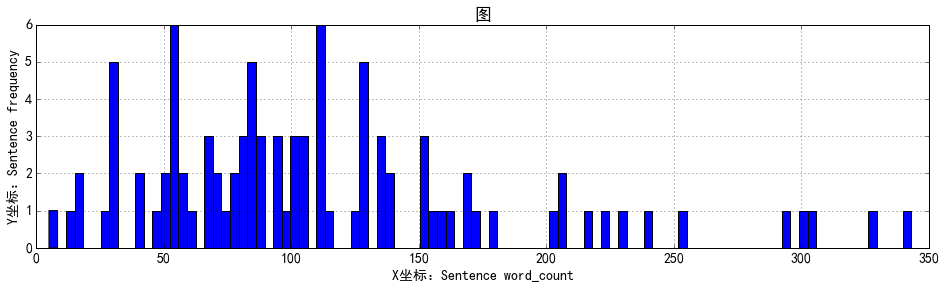

In [37]:
# 图表显示：
plt.figure(figsize=(16, 4))
plt.title(u'图')  
plt.xlabel(u'X坐标：Sentence word_count')  
plt.ylabel(u'Y坐标：Sentence frequency')  
# df_article['word_count'].value_counts().sort_values(ascending=False).plot(kind='bar', color='green')
df_article['word_count'].hist(bins=100)
# plt.gca().invert_yaxis()
plt.show()


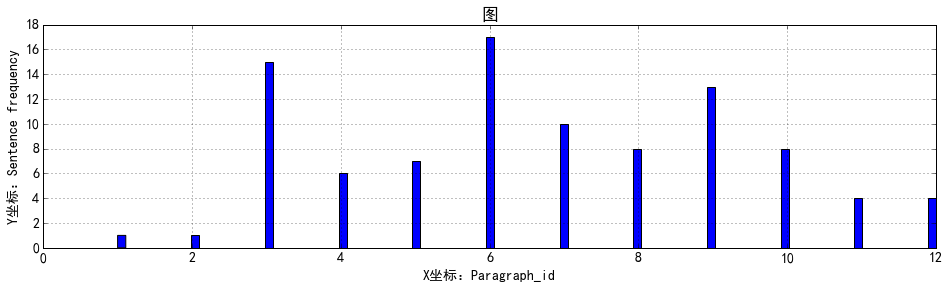

In [38]:
# 图表显示：
plt.figure(figsize=(16, 4))
plt.title(u'图')  
plt.xlabel(u'X坐标：Paragraph_id')  
plt.ylabel(u'Y坐标：Sentence frequency')  
df_article['paragraph_id'].hist(bins=100)
# plt.gca().invert_yaxis()
plt.show()


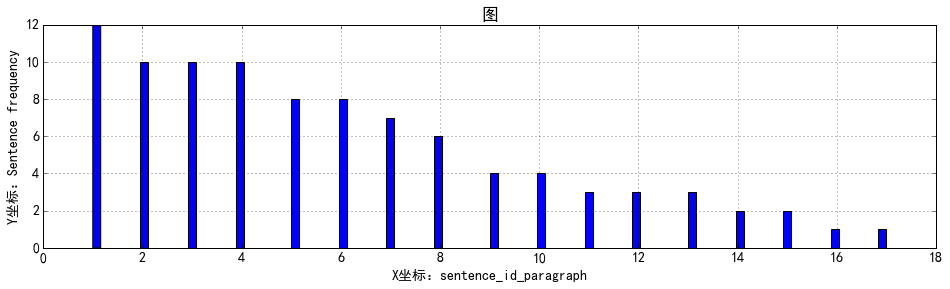

In [39]:
# 图表显示：
plt.figure(figsize=(16, 4))
plt.title(u'图')  
plt.xlabel(u'X坐标：sentence_id_paragraph')  
plt.ylabel(u'Y坐标：Sentence frequency')  
df_article['sentence_id_paragraph'].hist(bins=100)
# plt.gca().invert_yaxis()
plt.show()


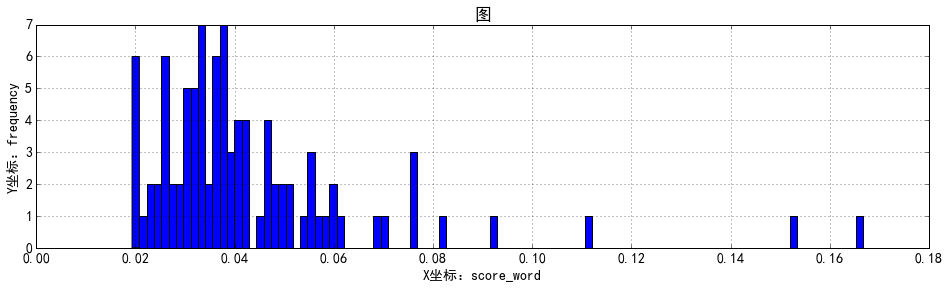

In [40]:
# 图表显示：
plt.figure(figsize=(16, 4))
plt.title(u'图')  
plt.xlabel(u'X坐标：score_word')  
plt.ylabel(u'Y坐标：frequency')  
df_article['score_word'].hist(bins = 100)
# plt.xscale('log')
# plt.yscale('log')
#plt.xlim(0,0.5)
#plt.ylim(0,0.5)
# plt.gca().invert_yaxis()
plt.show()


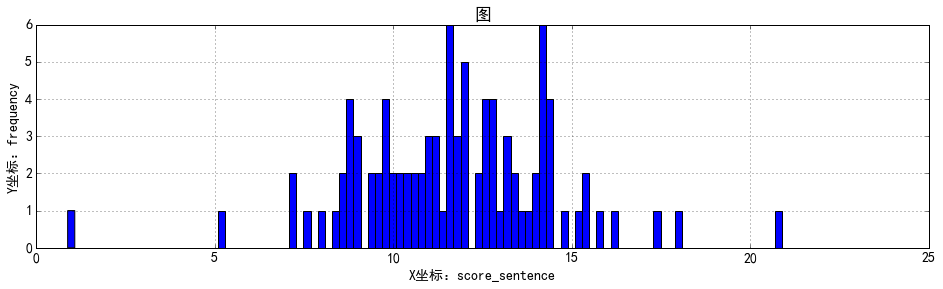

In [41]:
# 图表显示：
plt.figure(figsize=(16, 4))
plt.title(u'图')  
plt.xlabel(u'X坐标：score_sentence')  
plt.ylabel(u'Y坐标：frequency')  
df_article['score_sentence'].hist(bins = 100)
# plt.xscale('log')
# plt.yscale('log')
#plt.xlim(0,0.5)
#plt.ylim(0,0.5)
# plt.gca().invert_yaxis()
plt.show()


In [42]:
# df_article[(df_article['score_word'] > 0.15) & (df_article['score_word'] < 0.25)]
# df_article[(df_article['score_word'] > 0.2)].sort_values(by=['score_sentence', 'score_word'], ascending=[False, False,])
# df_article[(df_article['score_sentence'] > 250)].sort_values(by=['score_word', 'score_sentence'], ascending=[False, False,])


### Score Normalization

In [43]:
# log(score_word)
df_article['score_word_log'] = np.log(df_article['score_word'].astype('float64') + 
                                      df_article[df_article['score_word'] >0 ]['score_word'].min()/2)


In [44]:
# Normalize score_word_log - Zero mean, unit variance

# df_article['score_word_norm'] = (df_article['score_word'] - df_article['score_word'].mean()) / df_article['score_word'].std()
df_article['score_word_norm'] = (df_article['score_word_log'] - df_article['score_word_log'].mean()) / df_article['score_word_log'].std()

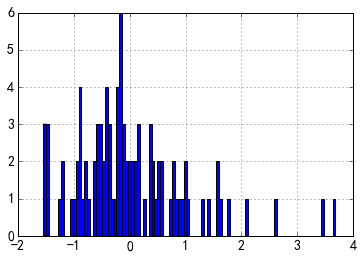

In [45]:
df_article['score_word_norm'].hist(bins=100)

In [46]:
# Normalize score_sentence - Zero mean, unit variance

df_article['score_sentence_norm'] = (df_article['score_sentence'] - df_article['score_sentence'].mean()) / df_article['score_sentence'].std()

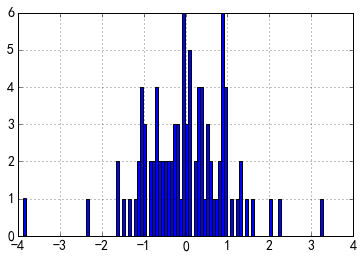

In [47]:
df_article['score_sentence_norm'].hist(bins=100)

### Generate class_rank

In [48]:
# Score integration
# df_article['score'] = (df_article['score_sentence_norm'] + df_article['score_word_norm']) / 2

# Sam Gu: 23 Mar 2017 - Experiment found that the score_word, which is based on tf-idf, doesn't seem to work well.
#                       score_word     tends to favor short sentences
#                       score_sentence tends to favor long  sentences
#                       Hence, here we use score_sentence only for final scoring.

# df_article['score'] = (df_article['score_word'] + df_article['score_sentence'] ) / 2
df_article['score'] = df_article['score_sentence']

In [49]:
# Min-Max normalization:
df_article['score'] = (df_article['score'] - df_article['score'].min()) / (df_article['score'].max() -df_article['score'].min())

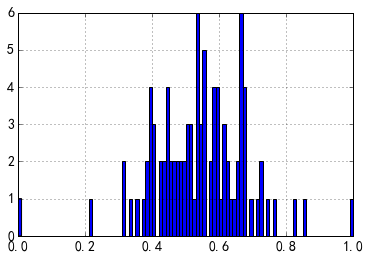

In [50]:
df_article['score'].hist(bins=100)

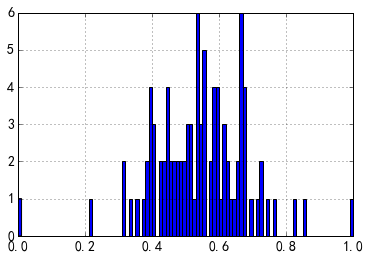

In [51]:
df_article['score'].hist(bins=100)

In [52]:
# sort firstly
df_article = df_article.sort_values(by=['paragraph_id', 'score'], ascending=[True, False]).reset_index(drop=True)

### Below step runs long time... Tuning needed

In [53]:
# Generate Class_Rank

current_class_rank = 0
current_paragraph_id = 0

for i in range(0, len(df_article)):
    if df_article['paragraph_id'][i] != current_paragraph_id: # change of Paragraph, thus reset class_rank
        current_class_rank = 1
        current_paragraph_id = df_article['paragraph_id'][i]
    else:
        current_class_rank = current_class_rank + 1
        
    df_article['class_rank'][i] = current_class_rank


G:\Tool_PGM\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [54]:
# sort Dataframe to 'result lookup mode'
df_article = df_article.sort_values(by=['class_rank', 'score', 'paragraph_id', 'sentence_id'], 
                                    ascending=[True, False, True, True]).reset_index(drop=True)

In [55]:
df_article[['sentence',
           'paragraph_id',
           'sentence_id_paragraph',
           'class_rank',
           'score',
           'sentence_tokenized'
          ]]

,sentence,paragraph_id,sentence_id_paragraph,class_rank,score,sentence_tokenized
0,Chen Qingyang find me to prove that she is not...,4,1,1,1,Chen Qingyang find me to prove that she is not...
1,I think so: if I want to prove that she is not...,8,1,1,0.851681,I think so if I want to prove that she is not...
2,I can logically prove that she is not breaking...,3,12,1,0.829022,I can logically prove that she is not breaking...
3,"I said, to prove that we are innocent, only to...",10,6,1,0.74047,I said to prove that we are innocent only to...
4,Chen Ching Yang said she did not despise shoes...,5,1,1,0.69867,Chen Ching Yang said she did not despise shoes...
5,"If I knew she had such a plan, maybe the back ...",12,4,1,0.675902,If I knew she had such a plan maybe the back ...
6,I tend to prove that I am not innocent. 我倒倾向于证...,11,3,1,0.672144,I tend to prove that I am not innocent 我 倒 倾...
7,"These holes make her have a hope, that is, may...",7,9,1,0.664615,These holes make her have a hope that is may...
8,"As for why we say that you are broken shoes, a...",6,7,1,0.664186,As for why we say that you are broken shoes a...
9,Not to mention the captain if it can provoke a...,9,7,1,0.620772,Not to mention the captain if it can provoke a...


In [56]:
# df_article[(df_article['score'] == 0) | (df_article['score'] == 1)]

# Extract results based on user parameters:
* Max number of words
* % of original number of words
* Max lines of sentences


In [57]:
# Make a dataframe copy
# Currently, the two dataframes are exactly the same.
df_article_internal = pd.DataFrame.copy(df_article)

In [58]:
total_words_original_article = df_article['sentence'].map(len).sum()
total_words_internal_article = df_article_internal['sentence'].map(len).sum()
# total_words_article_summary  = df_article_final['sentence'].map(len).sum()

# print('total_words_original_article : ', total_words_original_article)
# print('total_words_internal_article : ', total_words_internal_article)
# print('total_words_article_summary  : ', total_words_article_summary)


In [59]:
# Sam Gu: experiment shows no major improvement to use code in this block:

'''

# Heuristic cleaning:
# 1.Remove sentences, which has only one valid word. 
# 2.Remove paragraph, which has only single sentence.

# 1.
df_article_internal = df_article_internal[df_article_internal['sentence_tokenized'].map(len) > 1]
print('*** www.KudosData.com *** Removed number of sentences, which has only one valid word : %d'
      % (len(df_article) - len(df_article_internal)))

# 2.
df_article_internal_paragraph = df_article_internal['paragraph_id'].value_counts().to_frame(name = 'sentence_count')
df_article_internal_paragraph = df_article_internal_paragraph[df_article_internal_paragraph['sentence_count'] > 1]
valid_paragraph_id = df_article_internal_paragraph.index.tolist()
df_article_internal = df_article_internal[df_article_internal['paragraph_id'].isin(valid_paragraph_id)] 
print('*** www.KudosData.com *** Removed number of sentences in total : %d' % (len(df_article) - len(df_article_internal)))

# sort Dataframe to 'result lookup mode'
df_article_internal = df_article_internal.sort_values(by=['class_rank', 'score', 'paragraph_id', 'sentence_id'], 
                                    ascending=[True, False, True, True]).reset_index(drop=True)
# Above sort a must sort !!! for below processing:
# Loop Dataframe, accumulate length of sentences, stop when parm_max_word reached, return the index(), cut dataframe to display

'''

"\n\n# Heuristic cleaning:\n# 1.Remove sentences, which has only one valid word. \n# 2.Remove paragraph, which has only single sentence.\n\n# 1.\ndf_article_internal = df_article_internal[df_article_internal['sentence_tokenized'].map(len) > 1]\nprint('*** www.KudosData.com *** Removed number of sentences, which has only one valid word : %d'\n      % (len(df_article) - len(df_article_internal)))\n\n# 2.\ndf_article_internal_paragraph = df_article_internal['paragraph_id'].value_counts().to_frame(name = 'sentence_count')\ndf_article_internal_paragraph = df_article_internal_paragraph[df_article_internal_paragraph['sentence_count'] > 1]\nvalid_paragraph_id = df_article_internal_paragraph.index.tolist()\ndf_article_internal = df_article_internal[df_article_internal['paragraph_id'].isin(valid_paragraph_id)] \nprint('*** www.KudosData.com *** Removed number of sentences in total : %d' % (len(df_article) - len(df_article_internal)))\n\n# sort Dataframe to 'result lookup mode'\ndf_article_intern

### Accept user parameters:

In [79]:
# valid range: >= 0
parm_max_word = 200

# valid range: >= 0
parm_max_sentence = 10

# valid range: [0, 100%]
parm_max_percent = 0.01

### Validation of user parameters:

In [80]:
if (isinstance(parm_max_word, int) | isinstance(parm_max_word, float)):
    if parm_max_word >= 0:
        print('!1! valid input parm_max_word : ', parm_max_word)
    else:
        print('!2! Invalid input parm_max_word : ', parm_max_word)    
else:
    print('!3! Invalid input parm_max_word : ', parm_max_word)

if (isinstance(parm_max_sentence, int) | isinstance(parm_max_sentence, float)):
    if parm_max_sentence >= 0:
        print('!1! valid input parm_max_sentence : ', parm_max_sentence)
    else:
        print('!2! Invalid input parm_max_sentence : ', parm_max_sentence)    
else:
    print('!3! Invalid input parm_max_sentence : ', parm_max_sentence)

if (isinstance(parm_max_percent, int) | isinstance(parm_max_percent, float)):
    if parm_max_percent >= 0:
        print('!1! valid input parm_max_percent : ', parm_max_percent)
    else:
        print('!2! Invalid input parm_max_percent : ', parm_max_percent)    
else:
    print('!3! Invalid input parm_max_percent : ', parm_max_percent)


!1! valid input parm_max_word :  200
!1! valid input parm_max_sentence :  10
!1! valid input parm_max_percent :  0.01


In [81]:
# cut by parm_max_percent

# Loop Dataframe, accumulate length of sentences, stop when parm_max_word reached, return the index(), cut dataframe to display

sum_current_word = 0
cut_index = len(df_article_internal['sentence'])

# print('Start loop...')
for s in range(0, len(df_article_internal['sentence'])):
#     print('s : %d' % s)
    if sum_current_word / total_words_original_article <= parm_max_percent:
        sum_current_word += len(df_article_internal['sentence'][s])
    else:
#         stop, return index number
        cut_index = s - 1
        sum_current_word -= len(df_article_internal['sentence'][s-1])

#         print('To break')
        break

# print('End loop')
sum_current_percent = sum_current_word / total_words_original_article
print('---------- cut by parm_max_percent :')
print('sum_current_word  / total_words_original_article:', sum_current_percent)
print('cut_index : ', cut_index)

---------- cut by parm_max_percent :
sum_current_word  / total_words_original_article: 0.0
cut_index :  0


In [82]:
# cut by parm_max_word

# Loop Dataframe, accumulate length of sentences, stop when parm_max_word reached, return the index(), cut dataframe to display

sum_current_word = 0
cut_index = len(df_article_internal['sentence'])

# print('Start loop...')
for s in range(0, len(df_article_internal['sentence'])):
#     print('s : %d' % s)
    if sum_current_word <= parm_max_word:
        sum_current_word += len(df_article_internal['sentence'][s])
    else:
#         stop, return index number
        cut_index = s - 1
        sum_current_word -= len(df_article_internal['sentence'][s-1])
#         print('To break')
        break

# print('End loop')
print('---------- cut by parm_max_word :')
print('sum_current_word :', sum_current_word)
print('cut_index : ', cut_index)

---------- cut by parm_max_word :
sum_current_word : 125
cut_index :  1


In [83]:
# cut by parm_max_sentence

cut_index = parm_max_sentence

print('---------- cut by parm_max_sentence :')
print('cut_index : ', cut_index)

---------- cut by parm_max_sentence :
cut_index :  10


In [84]:
# Extract top number of sentences as summary, based on: cut_index
df_article_final = df_article_internal[0:cut_index]

In [85]:
# sort by original sentence order 
df_article_final = df_article_final.sort_values(by=['sentence_id'], ascending=[True])
df_article_final[['sentence', 'paragraph_id', 'sentence_id_paragraph', 'class_rank', 'score']]

,sentence,paragraph_id,sentence_id_paragraph,class_rank,score
2,I can logically prove that she is not breaking...,3,12,1,0.829022
0,Chen Qingyang find me to prove that she is not...,4,1,1,1
4,Chen Ching Yang said she did not despise shoes...,5,1,1,0.69867
8,"As for why we say that you are broken shoes, a...",6,7,1,0.664186
7,"These holes make her have a hope, that is, may...",7,9,1,0.664615
1,I think so: if I want to prove that she is not...,8,1,1,0.851681
9,Not to mention the captain if it can provoke a...,9,7,1,0.620772
3,"I said, to prove that we are innocent, only to...",10,6,1,0.74047
6,I tend to prove that I am not innocent. 我倒倾向于证...,11,3,1,0.672144
5,"If I knew she had such a plan, maybe the back ...",12,4,1,0.675902


In [86]:
# total_words_original_article = df_article['sentence'].map(len).sum()
# total_words_internal_article = df_article_internal['sentence'].map(len).sum()
total_words_article_summary  = df_article_final['sentence'].map(len).sum()

print('total_words_original_article : ', total_words_original_article)
print('total_words_internal_article : ', total_words_internal_article)
print('total_words_article_summary  : ', total_words_article_summary)


total_words_original_article :  10662
total_words_internal_article :  10662
total_words_article_summary  :  1266


# Output results to a file

In [87]:
# print('\n'.join(list(df_article_final['sentence'])))

In [88]:

with io.open('output_topic_summary.txt','w',encoding='utf8') as f:
#     f.write("Original Length : %s" % total_words_original_article)
    f.write("No. Paragraphs  : %d" % df_article_internal['paragraph_id'].max())
    f.write("\n")
    f.write("Original Length : %s" % total_words_internal_article)
    f.write("\n")
    f.write("Summary  Length : %s" % total_words_article_summary)
    f.write("\n")
#     f.write("Summary  Ratio  : %s %%" % (100 * (sum_current_word / total_words_original_article)))
    f.write("Summary  Ratio  : %.2f %%" % (100 * (total_words_article_summary / total_words_internal_article)))
    f.write("\n")
    f.write("\n")
    f.write("Title of Article: %s" % title)
    f.write("\n")
    f.write("\n")
    f.write('\n'.join(list(df_article_final['sentence'])))
    f.close()
    